<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/Generative_Adversarial_Networks_(GAN)_%5Bnumpy_bitmap_apple%5D_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Conv2DTranspose, UpSampling2D
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
#from tensorflow.keras.optimizers import RMSprop
from keras.optimizers import RMSprop
from keras import backend
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_images = "/content/drive/MyDrive/Colab Notebooks/Datasets/data/full_numpy_bitmap_apple.npy"
data_org = np.load(input_images)
print('dataset original shape:', data_org.shape)

dataset original shape: (144722, 784)


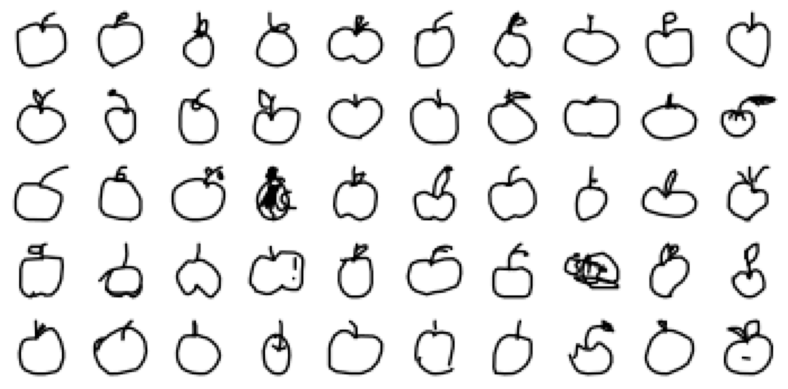

In [ ]:
plt.figure(figsize=(8,4))
l=np.random.randint(data_org.shape[0]-50)
for k in range(50):
    plt.subplot(5, 10, k+1)
    plt.imshow(data_org[k+l].reshape(28,28), cmap='Greys')
    plt.axis('off')

plt.tight_layout()
plt.show()

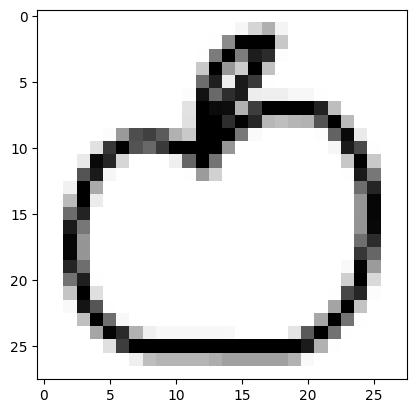

In [ ]:
plt.imshow(data_org[100].reshape(28,28), cmap='Greys')
plt.show()

In [ ]:
data = data_org/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
print('dataset reshape:', data.shape)
print('min:', data.min())
print('max:', data.max())

dataset reshape: (144722, 28, 28, 1)
min: 0.0
max: 1.0


In [ ]:
# Resets all state generated by Keras
backend.clear_session()

In [ ]:
def build_discriminator(depth=64, p=0.4):
  # Define inputs
  image = Input((img_w,img_h,1))
  # Convolutional layers
  conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
  conv1 = Dropout(p)(conv1)
  conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
  conv2 = Dropout(p)(conv2)
  conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
  conv3 = Dropout(p)(conv3)
  conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))
  # Output layer
  prediction = Dense(1, activation='sigmoid')(conv4)
  # Model definition
  model = Model(inputs=image, outputs=prediction, name='Discriminator')
  return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)       

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0008,
                      weight_decay=6e-8, clipvalue=1.0), metrics=['accuracy'])

In [ ]:
z_dimensions = 32

In [ ]:
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):

    # Define inputs
    noise = Input((latent_dim,))

    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)

    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)

    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)

    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition
    model = Model(inputs=noise, outputs=image, name='Genarator')

    return model

In [ ]:
generator = build_generator()
generator.summary()

Model: "Genarator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                         

In [ ]:
# GAN model
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred, name='GAN')
adversarial_model.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32)]              0         
                                                                 
 Genarator (Functional)      (None, 28, 28, 1)         183713    
                                                                 
 Discriminator (Functional)  (None, 1)                 4311553   
                                                                 
Total params: 4495266 (17.15 MB)
Trainable params: 177329 (692.69 KB)
Non-trainable params: 4317937 (16.47 MB)
_________________________________________________________________


In [ ]:
adversarial_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0004,
                          weight_decay=3e-8, clipvalue=1.0), metrics=['accuracy'])

In [ ]:
def plot_genarated_samples():
  noise = np.random.uniform(0, 1.0, size=[50, z_dimensions])
  gen_imgs = generator.predict(noise, verbose=0)
  plt.figure(figsize=(8,4))
  for k in range(gen_imgs.shape[0]):
    plt.subplot(5, 10, k+1)
    plt.imshow(gen_imgs[k, :, :, 0], cmap='Greys')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
def train(epochs=800, batch=128, z_dim=z_dimensions):
    d_metrics = []
    a_metrics = []
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    for i in range(epochs):
        # sample real images:
        real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))

        # generate fake images:
        #fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]), verbose=0)
        fake_imgs = generator.predict(np.random.uniform(0, 1.0, size=[batch, z_dim]), verbose=0)

        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))

        # assign y labels for discriminator:
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        # smoothing real and fake samples labels
        # y = np.ones([2*batch,1])*0.9
        # y[batch:,:] = 0.1

        # train discriminator:
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]

        # adversarial net's noise input and "real" y:
        #noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        noise = np.random.uniform(0, 1.0, size=[batch, z_dim])
        y = np.ones([batch,1])

        # train adversarial net:
        a_metrics.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        # periodically print progress & fake images:
        if (i % 10 == 0):
            i_ = i + 1
            # average losses and accuracy
            log_mesg = "Epoch %d: [D loss: %f, acc: %f]" % (i_, running_d_loss/i_, running_d_acc/i_)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i_, running_a_acc/i_)
            print(log_mesg)
            # clear display
            display.clear_output(wait=True)
            # plot GAN prediction samples
            plot_genarated_samples()

    print(log_mesg)
    return a_metrics, d_metrics

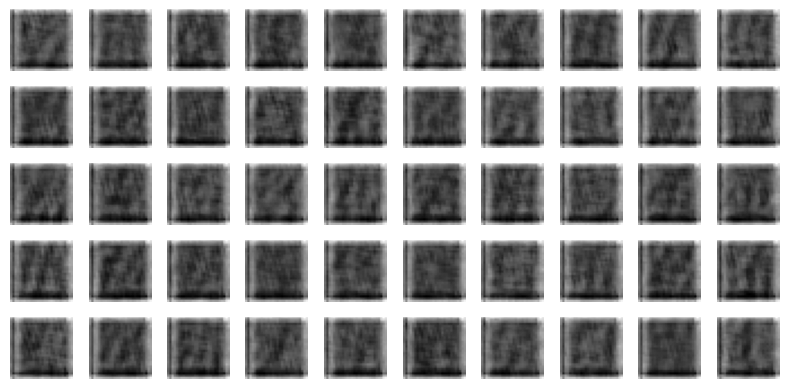

Epoch 21: [D loss: 0.541014, acc: 0.764323]  [A loss: 1.481824, acc: 0.298363]


In [ ]:
a_metrics_complete, d_metrics_complete = train(30)

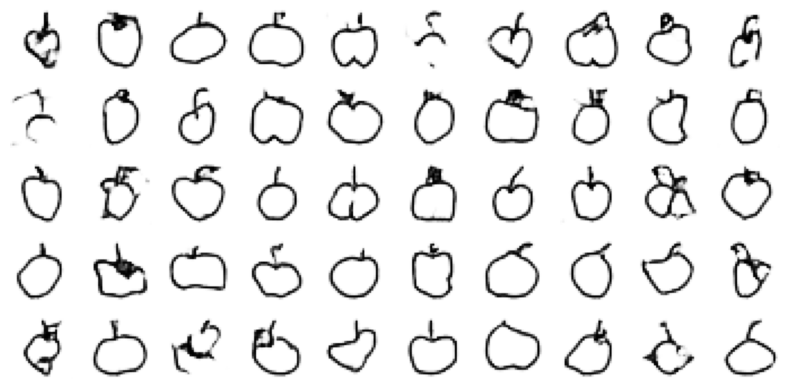

In [ ]:
# Trained GAN prediction samples
plot_genarated_samples()

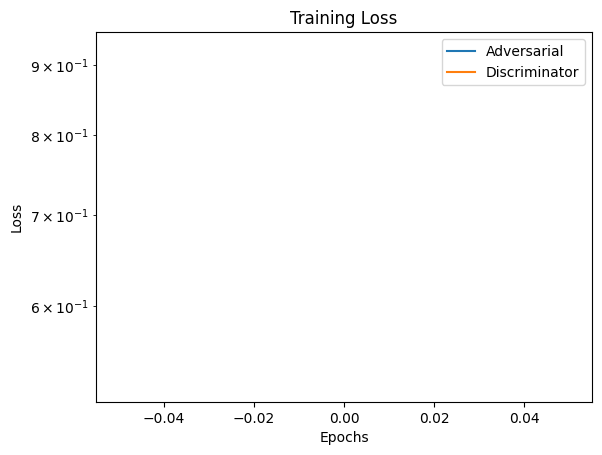

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
#ax.set_ylim(0.01,10)
plt.show()

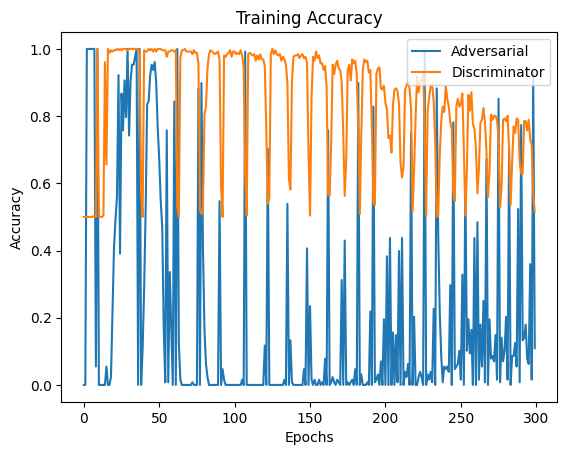

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.show()

##Referências
[1] https://arxiv.org/abs/1406.2661

[2] https://github.com/soumith/ganhacks

[3] https://kikaben.com/gangenerative-adversarial-network-simple-implementation-with-pytorch/

[4] https://arxiv.org/pdf/1611.07004v1.pdf

##Exercícios
1. Comentar e explicar as principais linhas de comando do algoritmo.
1. Modificar a matrix ramdômica de entrada da rede GAN (*z_dimensions*) para 64 e para 100. Observar o rendimento da rede e comentar os resultados.
1. Suavizar as amostras de treinamento da rede multiplicando por 0,9 as reais e por 0,1 as falsas. Verificar e comentar os resultados.
1. Plotar a média das perdas (loss function) e da acurácia (accuracy) ao longo das épocas. Comparar os resultados com os gráficos originais.
1. Rodar os bancos de dados utilizados nos exercícios anteriores e fazer uma tabela comparativa informando os bancos de dados e as arquiteturas de redes utilizadas, mostrando tempo de treinamento e precisão final dos resultados.
